<a href="https://colab.research.google.com/github/lovelyoyrmia/machine-learning-notebook/blob/main/public_cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat vs. Dog Image Classification With `ktrain`

We will use `ktrain` to fine-tune a `ResNet50` network pretrained on ImageNet for the Cats vs. Dogs dataset.  This dataset is a subset of 2000 JPG imgages from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. 

**NOTE:** Don't forget to set this notebook to use a GPU. go to `Runtime->Change runtime type` and select `GPU`.

Let's begin by installing the `ktrain` library and importing some modules that we'll need. If you see an `ERROR` related to the `gast` package, you can ignore it.

In [1]:
!pip3 install -q ktrain

     |████████████████████████████████| 25.3 MB 53.9 MB/s 
     |████████████████████████████████| 6.8 MB 36.5 MB/s 
     |████████████████████████████████| 981 kB 53.6 MB/s 
     |████████████████████████████████| 263 kB 50.2 MB/s 
     |████████████████████████████████| 2.8 MB 37.9 MB/s 
     |████████████████████████████████| 1.2 MB 32.1 MB/s 
     |████████████████████████████████| 468 kB 47.7 MB/s 
     |████████████████████████████████| 3.3 MB 44.8 MB/s 
     |████████████████████████████████| 596 kB 47.5 MB/s 
     |████████████████████████████████| 895 kB 49.4 MB/s 
     |████████████████████████████████| 61 kB 535 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [2]:
import ktrain
from ktrain import vision as vis

## Download the Data and Extract to `/tmp`

We will download the data and unzip it to the `/tmp` folder.

There will be two folders:
1. `train` contains the training images
2. `validation` ocntains the validation images



In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-12-11 09:58:00--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   117MB/s    in 0.6s    

2021-12-11 09:58:01 (117 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
!ls /tmp/cats_and_dogs_filtered

train  validation  vectorize.py


Let's peruse the images using `show_random_images`.

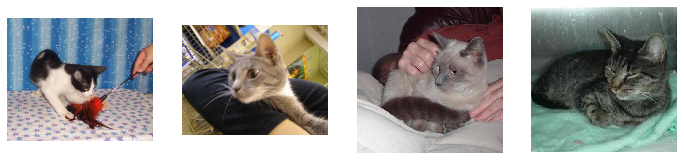

In [6]:
# some random images from the CATS folder
vis.show_random_images('/tmp/cats_and_dogs_filtered/train/cats')

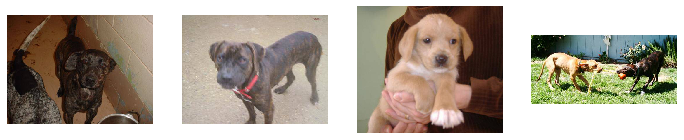

In [7]:
# some random images from the DOGS folder
vis.show_random_images('/tmp/cats_and_dogs_filtered/train/dogs')

## STEP 1: Load and Preprocess the Images

We will use the `images_from_folder` function to load the images as `DirectoryIterator` objects.  A `Preprocessor` instance is also returned as the third value, which we'll use later to preprocess raw images into the format expected by the model.

In [8]:
(trn, val, preproc) = vis.images_from_folder(
                                              datadir='/tmp/cats_and_dogs_filtered',
                                              data_aug = vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'validation'])

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## STEP 2: Create the Model and Wrap in `Learner`

In [9]:
model = vis.image_classifier('pretrained_resnet50', trn, val, freeze_layers=15)
learner = ktrain.get_learner(model=model, train_data=trn, val_data=val, 
                             workers=8, use_multiprocessing=False, batch_size=64)

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? False
94781440/94765736 [==============================] - 1s 0us/step
pretrained_resnet50 model created.


## STEP 3: Estimate Learning Rate

Let's simulate the training and gradually increase the learning rate until it diverges.  We will select a learning rate associated with a falling loss.

In [10]:
learner.lr_find(max_epochs=3)

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3
31/31 [==============================] - 63s 1s/step - loss: 1.7837 - accuracy: 0.5460
Epoch 2/3
31/31 [==============================] - 44s 1s/step - loss: 3.2309 - accuracy: 0.7784
Epoch 3/3
31/31 [==============================] - 13s 164ms/step - loss: 50.0800 - accuracy: 0.4906


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


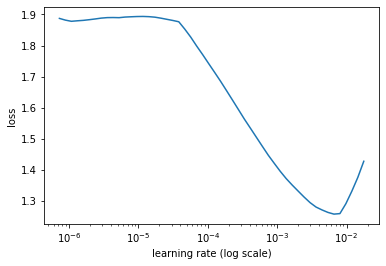

In [11]:
learner.lr_plot()

## STEP 4: Train the Model

We will only train for a single epoch for demonstration purposes.   With only one pass through the dataset our validaton accuracy is already more than 97%.

In [12]:
learner.fit_onecycle(1e-4, 1)



begin training using onecycle policy with max lr of 0.0001...
32/32 [==============================] - 72s 2s/step - loss: 0.7824 - accuracy: 0.7805 - val_loss: 0.0636 - val_accuracy: 0.9820


## Make Predictions

In [13]:
predictor = ktrain.get_predictor(learner.model, preproc)

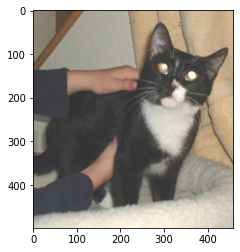

In [14]:
vis.show_image('/tmp/cats_and_dogs_filtered/validation/cats/cat.2000.jpg')

In [15]:
predictor.predict_filename('/tmp/cats_and_dogs_filtered/validation/cats/cat.2000.jpg')

['cats']

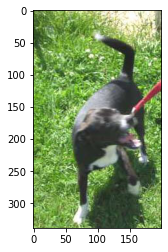

In [16]:
vis.show_image('/tmp/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg')

In [17]:
predictor.predict_filename('/tmp/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg')

['dogs']

In [18]:
# show predicted class "probabilities"
predictor.predict_filename('/tmp/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg', return_proba=True)

array([[1.1428028e-04, 9.9988568e-01]], dtype=float32)

In [19]:
predictor.get_classes()

['cats', 'dogs']

In [20]:
# save predictor (both model and preproc)
predictor.save('/tmp/catdog_predictor')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [21]:
!zip -r catdog_predictor.zip /tmp/catdog_predictor/

  adding: tmp/catdog_predictor/ (stored 0%)
  adding: tmp/catdog_predictor/tf_model.h5 (deflated 9%)
  adding: tmp/catdog_predictor/tf_model.preproc (deflated 38%)


In [22]:
# reload predictor
predictor = ktrain.load_predictor('/tmp/catdog_predictor')

In [23]:
# still works
predictor.predict_filename('/tmp/cats_and_dogs_filtered/validation/cats/cat.2000.jpg')

['cats']

In [32]:
from keras.models import load_model
import keras
import numpy as np

In [57]:
model = ktrain.load_predictor('/tmp/catdog_predictor/')

In [59]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [42]:
my_json

'{"class_name": "Functional", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 224, 224, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": false, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "name": "conv1_pad", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": false, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer

## Clean Up

Run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)